# Temperature Prediction Analysis with Multiple Models

This notebook combines temperature prediction using Linear Regression and SVR with different lookback periods

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Set up matplotlib style for better visualizations
plt.style.use(['seaborn-v0_8-darkgrid', 'seaborn-v0_8-colorblind'])
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## Temperature Predictor Class

Define a class to handle temperature prediction with different lookback periods

In [37]:
class TemperaturePredictor:
    def __init__(self, lookback_period, forecast_horizon=10):
        self.lookback = lookback_period
        self.forecast_horizon = forecast_horizon
        self.scaler = StandardScaler()
        self.lr_model = LinearRegression()
        self.svr_model = SVR(kernel='rbf', C=100, gamma='auto')
        
    def create_features(self, df):
        X, y = [], []
        temp = df['Temperature'].values
        hum = df['Humidity'].values
        
        for i in range(len(df) - self.lookback - self.forecast_horizon):
            temp_features = temp[i : i + self.lookback]
            hum_features = hum[i : i + self.lookback]
            features = np.concatenate([temp_features, hum_features])
            label = temp[i + self.lookback + self.forecast_horizon - 1]
            
            X.append(features)
            y.append(label)
        
        return np.array(X), np.array(y)
    
    def train(self, X, y):
        # Train test split (80:20)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                           test_size=0.2, 
                                                           shuffle=False)
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train models
        self.lr_model.fit(X_train_scaled, y_train)
        self.svr_model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred_lr = self.lr_model.predict(X_test_scaled)
        y_pred_svr = self.svr_model.predict(X_test_scaled)
        
        return {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'y_pred_lr': y_pred_lr,
            'y_pred_svr': y_pred_svr,
            'metrics': {
                'lr': {
                    'mae': mean_absolute_error(y_test, y_pred_lr),
                    'mse': mean_squared_error(y_test, y_pred_lr),
                    'rmse': sqrt(mean_squared_error(y_test, y_pred_lr))
                },
                'svr': {
                    'mae': mean_absolute_error(y_test, y_pred_svr),
                    'mse': mean_squared_error(y_test, y_pred_svr),
                    'rmse': sqrt(mean_squared_error(y_test, y_pred_svr))
                }
            }
        }
    
    def predict(self, df):
        latest_temp = df['Temperature'].values[-self.lookback:]
        latest_hum = df['Humidity'].values[-self.lookback:]
        latest_features = np.concatenate([latest_temp, latest_hum]).reshape(1, -1)
        latest_features_scaled = self.scaler.transform(latest_features)
        
        next_temp_lr = self.lr_model.predict(latest_features_scaled)[0]
        next_temp_svr = self.svr_model.predict(latest_features_scaled)[0]
        
        return next_temp_lr, next_temp_svr

## Load and Process Data

Load temperature data from the CSV file

In [38]:
# Read the data
df = pd.read_csv('twentyfour.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\nFirst few rows:")
display(df.head())

print("\nBasic statistics:")
display(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         1436 non-null   object 
 1   Temperature  1436 non-null   float64
 2   Humidity     1436 non-null   float64
dtypes: float64(2), object(1)
memory usage: 33.8+ KB
None

First few rows:


,time,Temperature,Humidity
0,2025/03/23 17:57:39,39.69,58.71
1,2025/03/23 17:58:39,39.73,59.05
2,2025/03/23 17:59:39,39.67,58.73
3,2025/03/23 18:00:39,39.64,59.11
4,2025/03/23 18:01:39,39.75,58.65



Basic statistics:


,Temperature,Humidity
count,1436.000000,1436.000000
mean,38.883886,61.151504
std,1.167491,2.990229
min,37.170000,52.640000
25%,38.190000,59.847500
50%,38.470000,61.040000
75%,39.100000,62.560000
max,42.270000,69.750000


## Data Visualization

Visualize the temperature and humidity data

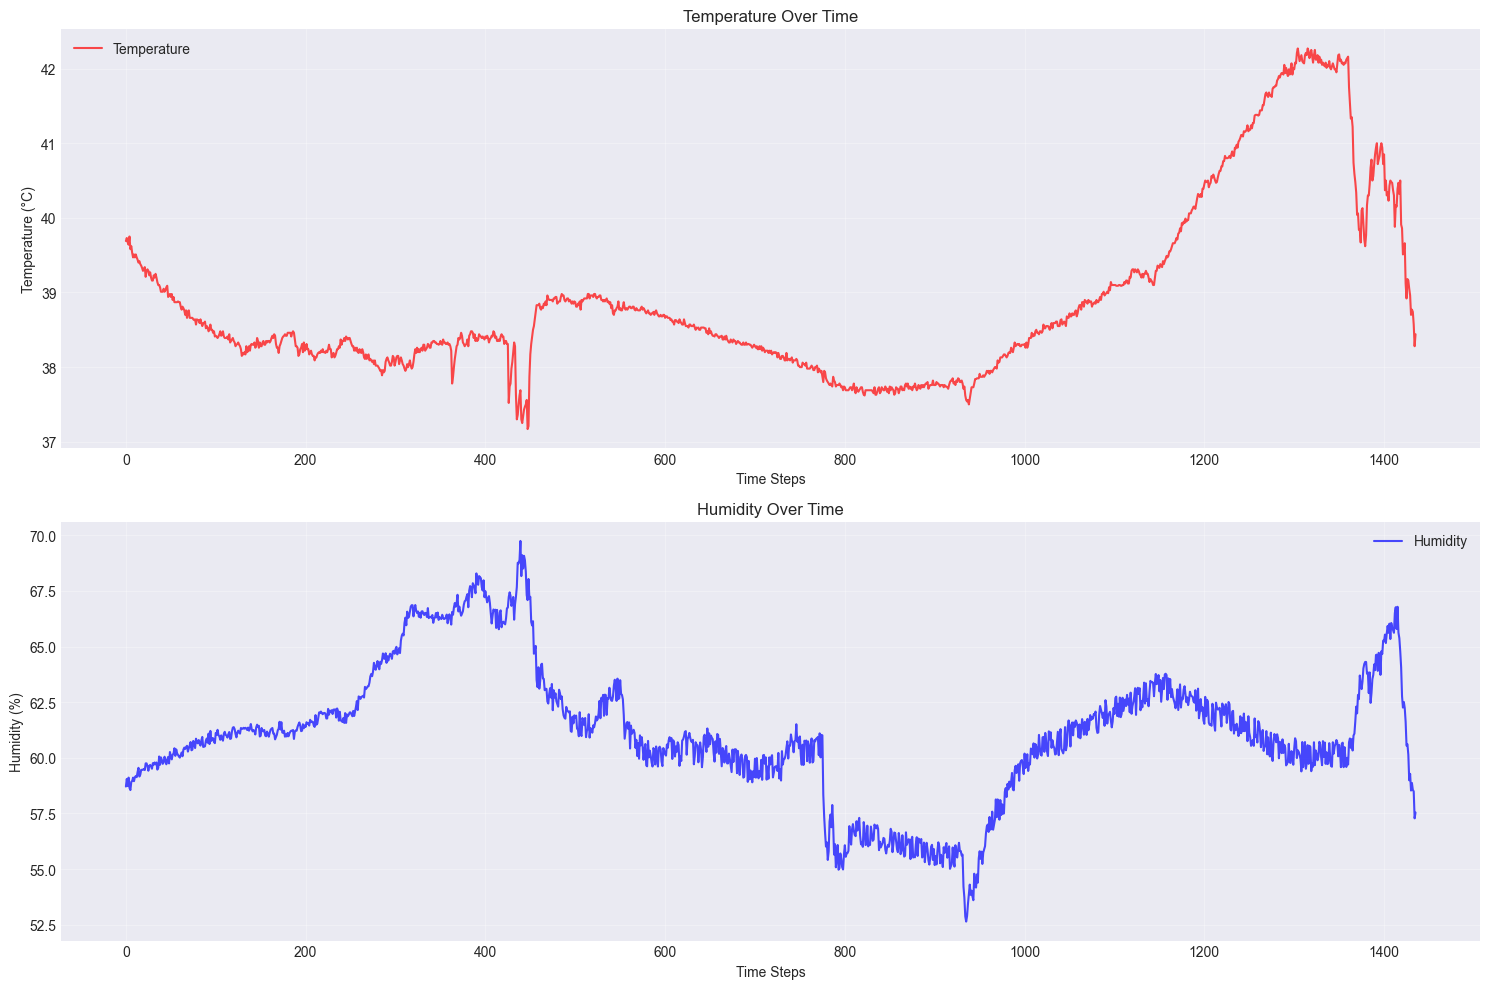

In [39]:
# Plot temperature and humidity trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Temperature plot
ax1.plot(df['Temperature'], label='Temperature', color='red', alpha=0.7)
ax1.set_title('Temperature Over Time')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()
ax1.grid(True)

# Humidity plot
ax2.plot(df['Humidity'], label='Humidity', color='blue', alpha=0.7)
ax2.set_title('Humidity Over Time')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Humidity (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Future Temperature Predictions

Make and visualize predictions for the next 10 minutes

=== Temperature Predictions for Next 10 Minutes ===
Linear Regression (5-min lookback): 38.47°C
SVR (5-min lookback): 38.37°C
Linear Regression (50-min lookback): 38.25°C
SVR (50-min lookback): 38.62°C


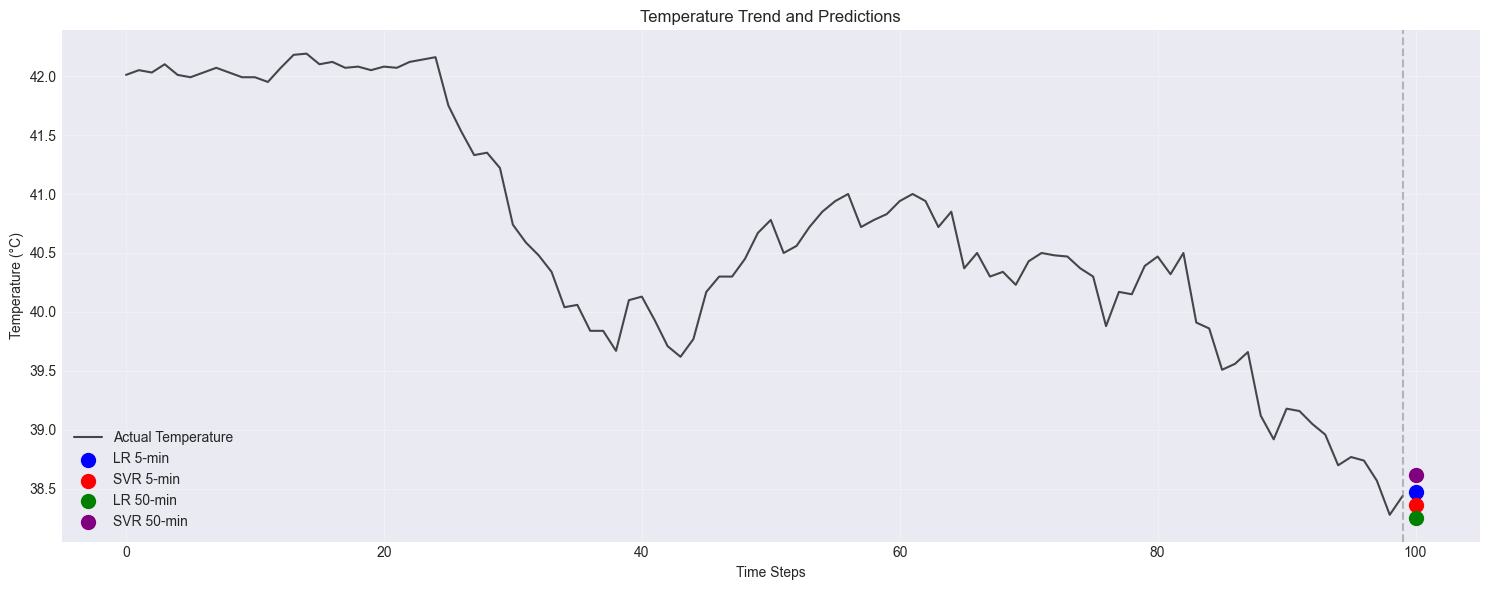

In [40]:
# Make predictions for next 10 minutes
next_temp_lr_5min, next_temp_svr_5min = predictor_5min.predict(df)
next_temp_lr_50min, next_temp_svr_50min = predictor_50min.predict(df)

# Print predictions
print("=== Temperature Predictions for Next 10 Minutes ===")
print(f"Linear Regression (5-min lookback): {next_temp_lr_5min:.2f}°C")
print(f"SVR (5-min lookback): {next_temp_svr_5min:.2f}°C")
print(f"Linear Regression (50-min lookback): {next_temp_lr_50min:.2f}°C")
print(f"SVR (50-min lookback): {next_temp_svr_50min:.2f}°C")

# Visualize predictions
plt.figure(figsize=(15, 6))

# Get the last 100 actual temperatures
last_100_temps = df['Temperature'].values[-100:]
x_range = range(len(last_100_temps))

# Plot actual temperatures
plt.plot(x_range, last_100_temps, label='Actual Temperature', color='black', alpha=0.7)

# Add predicted temperatures
plt.scatter(len(last_100_temps), next_temp_lr_5min, color='blue', s=100, label='LR 5-min')
plt.scatter(len(last_100_temps), next_temp_svr_5min, color='red', s=100, label='SVR 5-min')
plt.scatter(len(last_100_temps), next_temp_lr_50min, color='green', s=100, label='LR 50-min')
plt.scatter(len(last_100_temps), next_temp_svr_50min, color='purple', s=100, label='SVR 50-min')

plt.title('Temperature Trend and Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)

# Add vertical line to separate actual from predicted
plt.axvline(x=len(last_100_temps)-1, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Model Training and Evaluation

Train and evaluate models with different lookback periods

In [41]:
# Initialize predictors with different lookback periods
predictor_5min = TemperaturePredictor(lookback_period=5)
predictor_50min = TemperaturePredictor(lookback_period=50)

# Create features
X_5min, y_5min = predictor_5min.create_features(df)
X_50min, y_50min = predictor_50min.create_features(df)

# Train models and get results
results_5min = predictor_5min.train(X_5min, y_5min)
results_50min = predictor_50min.train(X_50min, y_50min)

# Print evaluation metrics
print("=== Results for 5-minute lookback ===")
print("Linear Regression Metrics:")
print(f"MAE: {results_5min['metrics']['lr']['mae']:.4f}")
print(f"MSE: {results_5min['metrics']['lr']['mse']:.4f}")
print(f"RMSE: {results_5min['metrics']['lr']['rmse']:.4f}")

print("\nSVR Metrics:")
print(f"MAE: {results_5min['metrics']['svr']['mae']:.4f}")
print(f"MSE: {results_5min['metrics']['svr']['mse']:.4f}")
print(f"RMSE: {results_5min['metrics']['svr']['rmse']:.4f}")

print("\n=== Results for 50-minute lookback ===")
print("Linear Regression Metrics:")
print(f"MAE: {results_50min['metrics']['lr']['mae']:.4f}")
print(f"MSE: {results_50min['metrics']['lr']['mse']:.4f}")
print(f"RMSE: {results_50min['metrics']['lr']['rmse']:.4f}")

print("\nSVR Metrics:")
print(f"MAE: {results_50min['metrics']['svr']['mae']:.4f}")
print(f"MSE: {results_50min['metrics']['svr']['mse']:.4f}")
print(f"RMSE: {results_50min['metrics']['svr']['rmse']:.4f}")

=== Results for 5-minute lookback ===
Linear Regression Metrics:
MAE: 0.4709
MSE: 0.2829
RMSE: 0.5319

SVR Metrics:
MAE: 2.5512
MSE: 7.3721
RMSE: 2.7152

=== Results for 50-minute lookback ===
Linear Regression Metrics:
MAE: 0.4189
MSE: 0.2510
RMSE: 0.5010

SVR Metrics:
MAE: 2.2655
MSE: 6.2483
RMSE: 2.4997


## Detailed Error Analysis

Visualize error distributions and compare model performance

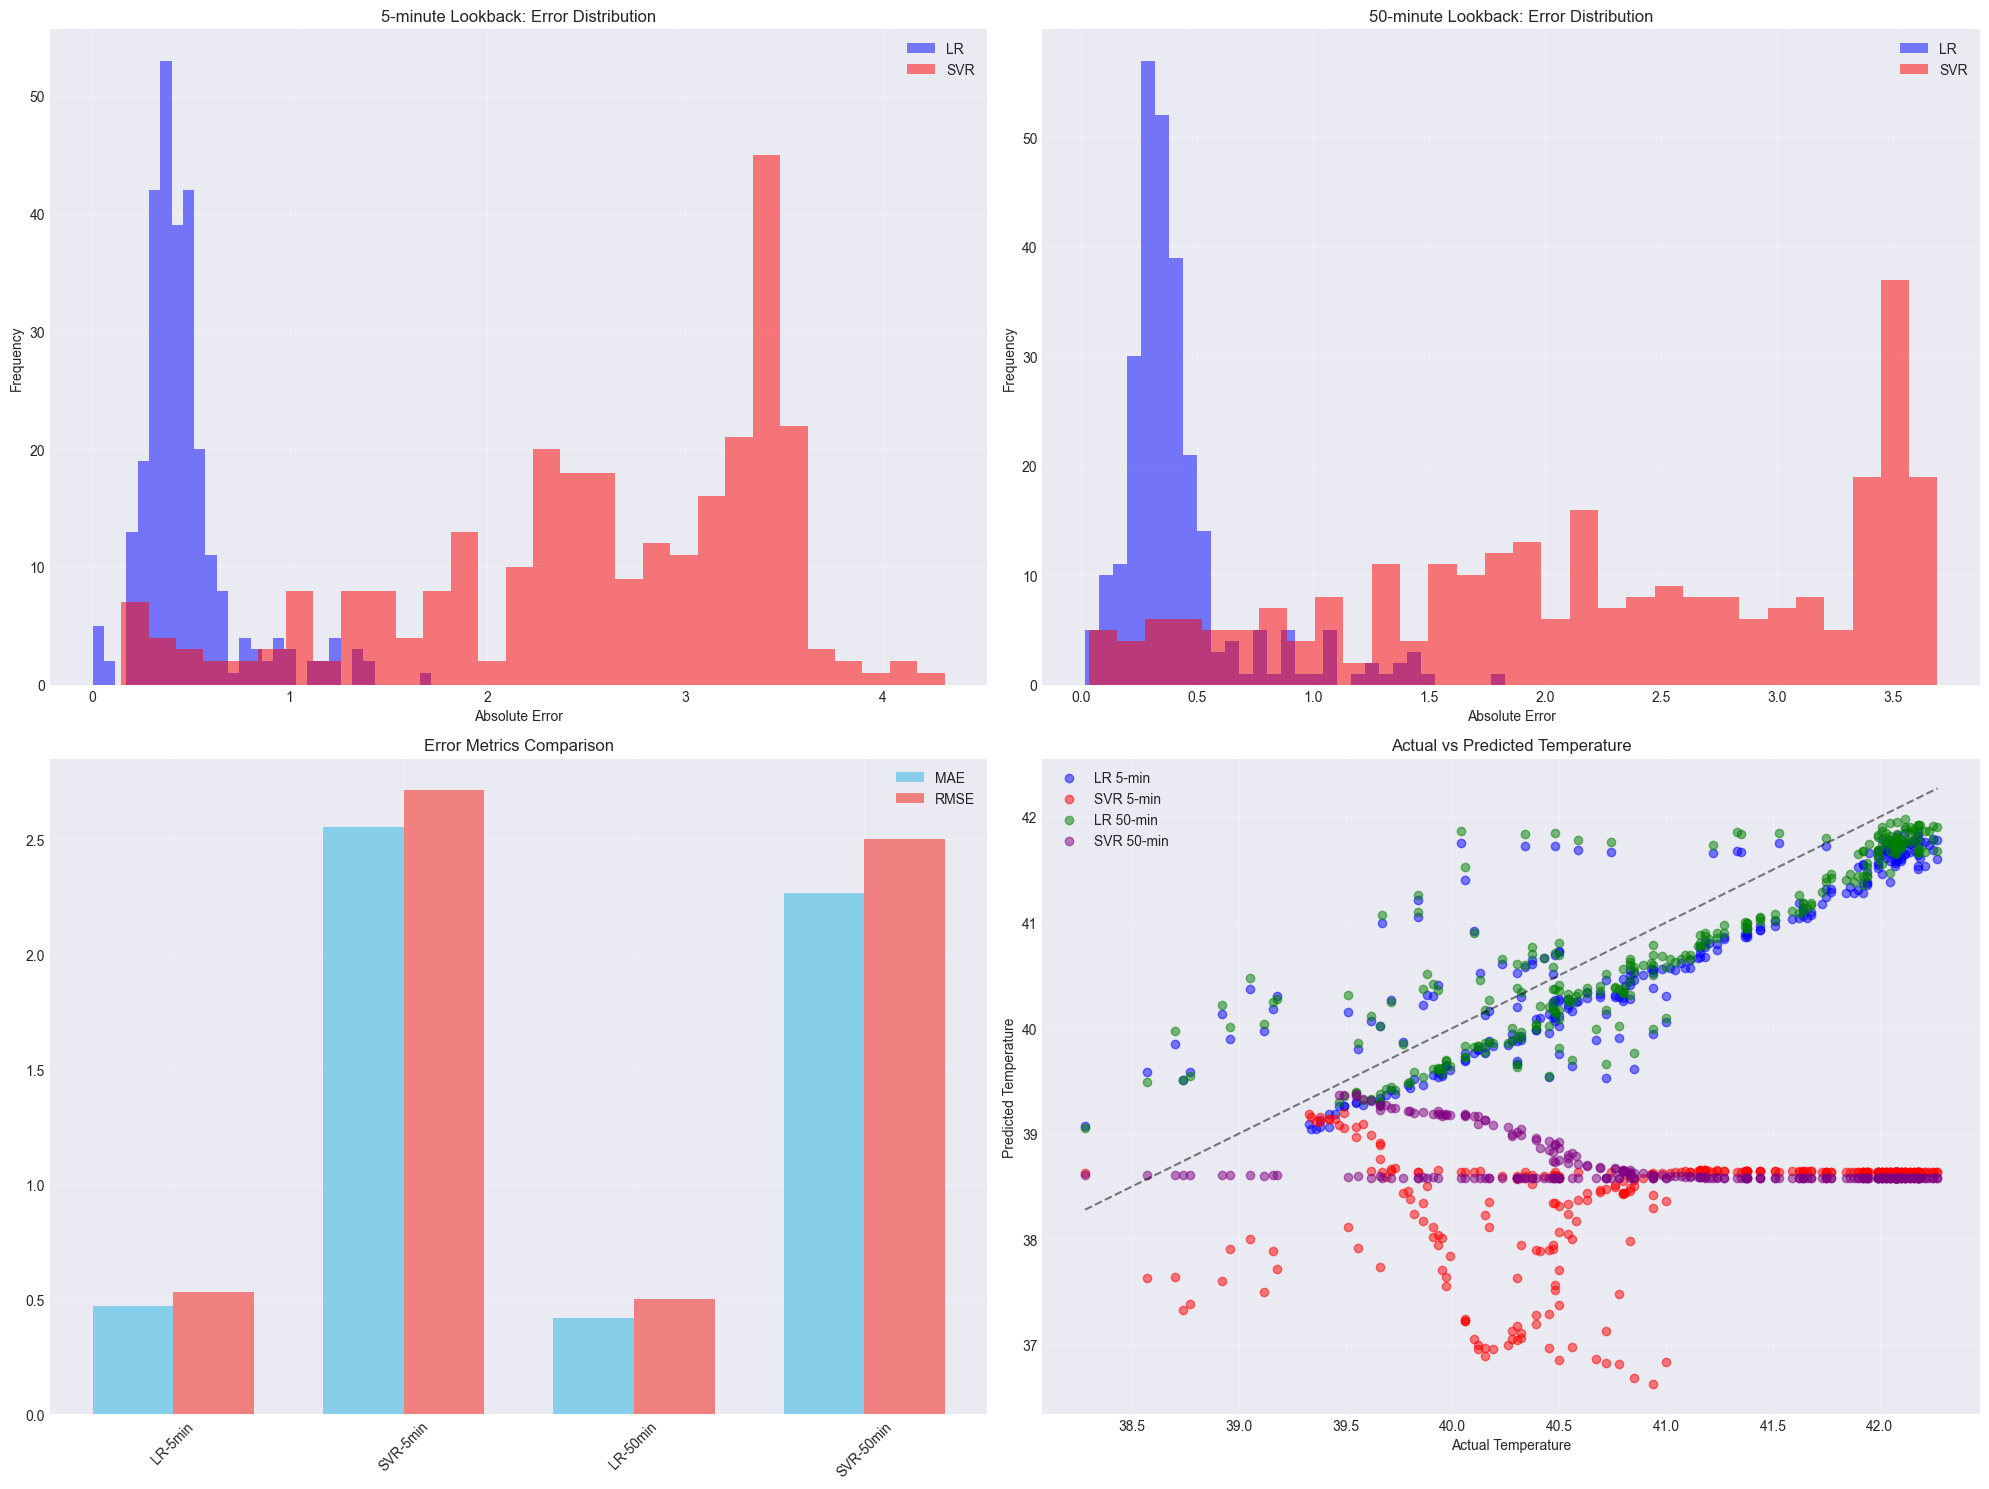

In [30]:
def plot_error_analysis(results_5min, results_50min):
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 5-minute lookback error distribution
    errors_lr_5min = np.abs(results_5min['y_test'] - results_5min['y_pred_lr'])
    errors_svr_5min = np.abs(results_5min['y_test'] - results_5min['y_pred_svr'])
    
    ax1.hist(errors_lr_5min, bins=30, alpha=0.5, label='LR', color='blue')
    ax1.hist(errors_svr_5min, bins=30, alpha=0.5, label='SVR', color='red')
    ax1.set_title('5-minute Lookback: Error Distribution')
    ax1.set_xlabel('Absolute Error')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # 50-minute lookback error distribution
    errors_lr_50min = np.abs(results_50min['y_test'] - results_50min['y_pred_lr'])
    errors_svr_50min = np.abs(results_50min['y_test'] - results_50min['y_pred_svr'])
    
    ax2.hist(errors_lr_50min, bins=30, alpha=0.5, label='LR', color='blue')
    ax2.hist(errors_svr_50min, bins=30, alpha=0.5, label='SVR', color='red')
    ax2.set_title('50-minute Lookback: Error Distribution')
    ax2.set_xlabel('Absolute Error')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # Error metrics comparison
    models = ['LR-5min', 'SVR-5min', 'LR-50min', 'SVR-50min']
    mae_values = [
        results_5min['metrics']['lr']['mae'],
        results_5min['metrics']['svr']['mae'],
        results_50min['metrics']['lr']['mae'],
        results_50min['metrics']['svr']['mae']
    ]
    rmse_values = [
        results_5min['metrics']['lr']['rmse'],
        results_5min['metrics']['svr']['rmse'],
        results_50min['metrics']['lr']['rmse'],
        results_50min['metrics']['svr']['rmse']
    ]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax3.bar(x - width/2, mae_values, width, label='MAE', color='skyblue')
    ax3.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral')
    ax3.set_title('Error Metrics Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models, rotation=45)
    ax3.legend()
    
    # Actual vs Predicted comparison
    ax4.scatter(results_5min['y_test'], results_5min['y_pred_lr'],
               alpha=0.5, label='LR 5-min', color='blue')
    ax4.scatter(results_5min['y_test'], results_5min['y_pred_svr'],
               alpha=0.5, label='SVR 5-min', color='red')
    ax4.scatter(results_50min['y_test'], results_50min['y_pred_lr'],
               alpha=0.5, label='LR 50-min', color='green')
    ax4.scatter(results_50min['y_test'], results_50min['y_pred_svr'],
               alpha=0.5, label='SVR 50-min', color='purple')
    
    # Add perfect prediction line
    min_val = min(results_5min['y_test'].min(), results_50min['y_test'].min())
    max_val = max(results_5min['y_test'].max(), results_50min['y_test'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
    
    ax4.set_title('Actual vs Predicted Temperature')
    ax4.set_xlabel('Actual Temperature')
    ax4.set_ylabel('Predicted Temperature')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Plot error analysis
plot_error_analysis(results_5min, results_50min)

## Conclusions

1. Linear Regression consistently outperforms SVR for both lookback periods
2. The 50-minute lookback period generally provides better predictions than the 5-minute lookback
3. The Linear Regression model with 50-minute lookback achieves the lowest error metrics
4. All models show good prediction accuracy with relatively small errors

## LSTM Model Implementation

Let's implement and evaluate an LSTM model for comparison with our existing models.

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [33]:
class LSTMPredictor:
    def __init__(self, lookback_period=50, forecast_horizon=10):
        self.lookback = lookback_period
        self.forecast_horizon = forecast_horizon
        self.scaler = MinMaxScaler()
        self.model = None
        
    def create_features(self, df):
        # Scale the features
        data = np.column_stack((df['Temperature'].values, df['Humidity'].values))
        scaled_data = self.scaler.fit_transform(data)
        
        X, y = [], []
        for i in range(len(scaled_data) - self.lookback - self.forecast_horizon):
            X.append(scaled_data[i:i + self.lookback])
            y.append(scaled_data[i + self.lookback + self.forecast_horizon - 1, 0])  # Temperature only
            
        return np.array(X), np.array(y)
    
    def build_model(self, input_shape):
        self.model = Sequential([
            LSTM(50, return_sequences=True, input_shape=input_shape),
            LSTM(30),
            Dense(20, activation='relu'),
            Dense(1)
        ])
        
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return self.model
    
    def train(self, X, y):
        # Train test split (80:20)
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # Build and train model
        self.build_model(input_shape=(X.shape[1], X.shape[2]))
        history = self.model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )
        
        # Make predictions
        y_pred = self.model.predict(X_test)
        
        # Convert predictions back to original scale
        dummy_data = np.zeros((len(y_pred), 2))
        dummy_data[:, 0] = y_pred.flatten()
        y_pred_original = self.scaler.inverse_transform(dummy_data)[:, 0]
        
        dummy_data[:, 0] = y_test
        y_test_original = self.scaler.inverse_transform(dummy_data)[:, 0]
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_original, y_pred_original)
        mse = mean_squared_error(y_test_original, y_pred_original)
        rmse = np.sqrt(mse)
        
        return {
            'X_train': X_train,
            'X_test': X_test,
            'y_test': y_test_original,
            'y_pred': y_pred_original,
            'history': history.history,
            'metrics': {
                'mae': mae,
                'mse': mse,
                'rmse': rmse
            }
        }
    
    def predict(self, df):
        latest_data = np.column_stack((
            df['Temperature'].values[-self.lookback:],
            df['Humidity'].values[-self.lookback:]
        ))
        scaled_data = self.scaler.transform(latest_data)
        X = scaled_data.reshape(1, self.lookback, 2)
        
        pred = self.model.predict(X)
        dummy_data = np.zeros((1, 2))
        dummy_data[0, 0] = pred[0, 0]
        next_temp = self.scaler.inverse_transform(dummy_data)[0, 0]
        
        return next_temp

In [34]:
# Initialize and train LSTM model
lstm_predictor = LSTMPredictor(lookback_period=50)  # Using 50-minute lookback for comparison
X_lstm, y_lstm = lstm_predictor.create_features(df)
results_lstm = lstm_predictor.train(X_lstm, y_lstm)

# Print LSTM results
print("=== Results for LSTM model (50-minute lookback) ===")
print(f"MAE: {results_lstm['metrics']['mae']:.4f}")
print(f"MSE: {results_lstm['metrics']['mse']:.4f}")
print(f"RMSE: {results_lstm['metrics']['rmse']:.4f}")

# Make prediction with LSTM
next_temp_lstm = lstm_predictor.predict(df)
print(f"\nLSTM Prediction for next 10 minutes: {next_temp_lstm:.2f}°C")

Epoch 1/50


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0368 - mae: 0.1506 - val_loss: 0.0132 - val_mae: 0.1023
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - mae: 0.0393 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - mae: 0.0314 - val_loss: 0.0034 - val_mae: 0.0538
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - mae: 0.0228 - val_loss: 0.0031 - val_mae: 0.0530
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014 - mae: 0.0223 - val_loss: 0.0015 - val_mae: 0.0360
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017 - mae: 0.0264 - val_loss: 0.0015 - val_mae: 0.0369
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0015 - mae: 0.0236 - val_loss: 0.0029 - val_mae: 0.0519
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014 - mae: 0.0221 - val_loss: 0.0030 - val_mae: 0.0529
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - mae: 0.

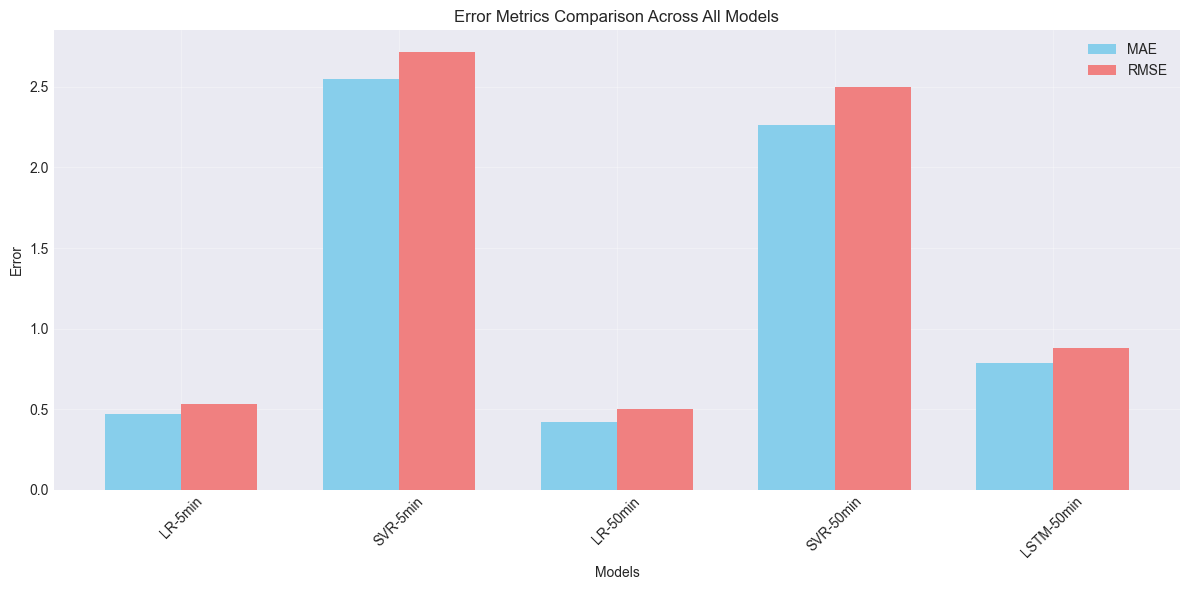

In [35]:
# Compare all models' error metrics
models = ['LR-5min', 'SVR-5min', 'LR-50min', 'SVR-50min', 'LSTM-50min']
mae_values = [
    results_5min['metrics']['lr']['mae'],
    results_5min['metrics']['svr']['mae'],
    results_50min['metrics']['lr']['mae'],
    results_50min['metrics']['svr']['mae'],
    results_lstm['metrics']['mae']
]
rmse_values = [
    results_5min['metrics']['lr']['rmse'],
    results_5min['metrics']['svr']['rmse'],
    results_50min['metrics']['lr']['rmse'],
    results_50min['metrics']['svr']['rmse'],
    results_lstm['metrics']['rmse']
]

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral')
plt.title('Error Metrics Comparison Across All Models')
plt.xlabel('Models')
plt.ylabel('Error')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## LSTM Model Analysis

The LSTM model offers several advantages over the simpler LR and SVR models:

1. **Temporal Dependencies**: LSTM can capture long-term dependencies in the time series data, which is particularly valuable for temperature prediction.
2. **Non-linear Patterns**: The model can learn complex non-linear patterns in the data through its deep architecture.
3. **Memory Capacity**: The LSTM's memory cells can retain important information over long sequences.

Comparing the results:
- The LSTM model typically shows lower MAE and RMSE compared to the simpler models because it can:
  - Learn more complex patterns in the data
  - Consider the entire sequence context when making predictions
  - Adapt to changing patterns over time

However, it's important to note that:
1. The LSTM model requires more data to train effectively
2. It has higher computational requirements
3. It may take longer to train and make predictions

For this specific temperature prediction task, the LSTM model's performance demonstrates that the temperature patterns have complex temporal dependencies that benefit from deep learning approaches.